
# Záróvizsga igazságossága

Az alábbi Notebook a BME-VIK Önálló labor (AUT) tárgyához készült és beosztástervezések igazságosságával foglalkozik.

Készítette: Seben Domonkos, 2022

**Az alkalmazás célja:** Felépíteni egy keretrendszert, mely képes valamilyen egyszerűen előállítható inputokat (valamilyen kész beosztás) kiértékelni azok igazságossága szerint. Fontos tulajdonsága a problémának, hogy többdimenziós regressziót kell alkalmaznunk.

A program az alábbi dimenziókat fogja figyelembe venni:
- betöltött szerep (*vizsgáztató, elnök, bizottsági tag, titkár*)
- ráeső hallgatók száma
- oktatott tárgyak száma



## 1. Demo

Kiindulásképp azt gondoltam át, milyen adatokat érdemes kinyerni egy kész beosztásból. Az alábbiakat hasznosnak tartottam: 
 1. hány tárgyat tanít egy tanár   
 2. az egyes tárgyakhoz hány tanár és hallgató jut -> átlagos hallgatók száma / tanár
 3. vizsgáztatóként hányszor van beosztva (ennek számolja alapból)
 4. elnökként hányszor van beosztva (ha nem vizsgázató)
 5. tagként hányszor van beosztva (ha nem elnök)
 
(*Alternatív megoldás a 3-5. pontokra:*  egy tanár egy beosztását elképzelhetjük egy 3 elemű vektorként, pl. `[1 0 1]` jelentheti, hogy a tanár vizsgáztatóként és tagként volt jelen. Én végül nem így dolgoztam fel a bemeneti fájlt, így arra a kérdésre nem tud a modellem válaszolni, hogy hányszor volt egy tanár egyszerre vizsgáztató és elnök. Azért gondolom, hogy ez felesleges lehet, mert a munkateher meghatározásához nem kellene kétszer beleszámolni ugyanazt a vizsgaalkalmat. Ha az igazságosság szempontjából mégis úgy döntünk, hogy munkateher szempontjából eltérő egy `[1 0 0]` és egy `[1 1 0]` eset, akkor a fájl feldolgozásakor ezt is tárolni kell.) 

Következő lépésben felállítottam egy példa adathalmazt, melyben az egyes oktatókhoz az alábbi értékeket rendeltem: 
 - hány vizsgán vesznek részt vizsgáztatóként
 - hány tárgyat tanítanak
 - tárgyakra bontva a vizsgázóik száma
 - tárgyakra bontva a hallgatóik száma \
Pl. az alábbi számok jellemzik 3 tanár tárgyainak és vizsgázatott hallgatóinak számát. 

In [2]:
A = {"examines": 34, "total_courses": 3, "exams_per_course": {1: 8, 2: 10, 3: 16}, "students_per_course": {1: 8, 2: 10, 3: 8}}
B = {"examines": 17, "total_courses": 1, "exams_per_course": {0: 17}, "students_per_course": {0: 17}}
C = {"examines": 4, "total_courses": 2, "exams_per_course": {3: 0, 4: 4}, "students_per_course": {3: 8, 4: 4}}

df = pd.DataFrame([A, B, C], index = ["A", "B", "C"])
df["spc_sum"] = df.apply(lambda x: sum(x.students_per_course.values()), axis = 1)
df

,examines,total_courses,exams_per_course,students_per_course,spc_sum
A,34,3,"{1: 8, 2: 10, 3: 16}","{1: 8, 2: 10, 3: 8}",26
B,17,1,{0: 17},{0: 17},17
C,4,2,"{3: 0, 4: 4}","{3: 8, 4: 4}",12


Alább pedig az egyes tárgyakról található példaadat:

In [3]:
Courses = {0: {"students": 17, "teachers": 1}, 
           1: {"students": 8, "teachers": 1 }, 
           2: {"students": 10, "teachers": 1}, 
           3: {"students": 16, "teachers": 2}, 
           4: {"students": 4, "teachers": 1}}

Talán érezhető, hogy a "C" tanár az igazságosabbnál kevesebb vizsgára került beosztásra. 
A példa adathalmazban az `exams_per_course` és `students_per_course` oszlopok nem túl elegánsak, ráadásul az utóbbi még redundáns információkat is tartalmaz. Mindkettő igazából csak bizonyos másik értékek meghatározásához kell. Az alábbi modellben így ezeket az oszlopokat elhagytam. 

### 1.1 Problémafelvetés

A modellnek erőteljesen zárt világ feltételezése van. Ha egy tanár pl. más tárgyakat is tanít, de ez nem derül ki a beosztásból, ez a tény nem lesz figyelembe véve. Ugyanígy, csak akkor mondhatjuk bizonyossággal, hogy egy tanár betölthet pl. elnöki pozíciót, ha van olyan beosztás, ahol elnök. 
> **Javaslat:** A bemenetből az alábbi kérdésekre biztosabb választ találni. (Pl. az elérhetőségek lapon megtalálható, hogy ki lehet elnök/tag/titkár.)

Előfordulhat, hogy a modell aránytalanságokat talál, de a valóságban ez kívánt viselkedés. Pl. egy tárgyvezető nagyobb százalékban kíván jelen lenni a vizsgákon, mint a többi oktató. Ha a beosztás is ezt figyelembe véve lett elkészítve, akkor az igazságosság megállapításakor pl. súlyokkal tudjuk ezt az információt kezelni. Az általam implementált modell ezzel nem foglalkozik.

## 2. Input feldolgozása

### 2.2 Használt indexek

A tárgyakat és tanárokat jellemző alábbi indexeket definiáltam: 

#### ETJH = egy tanárra jutó hallgatók

Egy vizsgatárgyra jellemző mérték, a tárgyból vizsgázó hallgatók számának és a tárgyból vizsgáztató oktatók számának hányadosa, egészre kerekítve.

#### OTI = oktatott tárgyak száma

Egy tanár esetében úgy kapjuk meg az alábbi mutatót, hogy a vizsgák közül kiválasztjuk azokat, ahol az adott tanár a vizsgáztató, majd ezen vizsgák vizsgatárgyaiból egy (egyedi) halmazt építünk. A halmaz elemszáma lesz a keresett érték.

#### KHI = kumulatív hallgatói index

Ismert, hogy az egyes tárgyakon hány hallgató vizsgázik. Ekkor egy tanár *KHI* értéke az általa tanított tárgyakból vizsgázó hallgató. 

#### ÁHI = átlagos hallgatói index

Ismert, hogy az egyes tárgyakra átlagosan hány hallgató jut egy oktatóra. Ekkor egy tanár *ÁHI* értéke az általa tanított tárgyakban, egy tanárra átlagosan jutó hallgatók számának összege.

A változónevekben előfordulhat, hogy az indexek angol megfelelőjét használom, ezek: 

    - taught course index (OTI)
    - cumulative student index (KHI)
    - average student index (ÁHI)

>**Megjegyzések:** 

- A *data* mappa tartalmaz számos kész beosztást tartalmazó excel fájlt (Sziszitől). Én csak a 2020-as fájlt dolgozom fel, elképzelhető így, hogy évről évre más konvenciókat követnek a fájlok pl. az oszlopneveket illetően. A `load_in_sample_data` függvény a 2020-as fájlt olvassa be és dolgozza fel az oszlopnevek átnevezése nélkül. Érdemes lehet egy leképező függvényt definiálni, ami bármelyik év fájljait tudja kezelni, ha bemenetnek (pl. egy könyvtár adatstruktúrával) megadjuk, hogy az implementációban használt DataFrame oszlopnevek melyik Excel oszlopneveknek felelnek meg, és a `load_in_schedule` függvényt kiterjeszteni, hogy az a leképező függvényt hívja meg. Ha szükséges, akkor ezután kezelhetőek a NaN értékek az összevont cellák és hiányos adatok miatt.

- Lehetséges, hogy az adathalmaz több excel tábla lapból áll, érdemes lehet ezt a problémát is kezelni.

- A `workload` függvényt érdemesebb példány metódusként implementálni. (A kód egy korábbi verziójában a munkateher kiszámítása is az `init_teachers` privát függvényben került kiszámításra, ahol nem volt lehetőség megszabni a súlyokat. A félév végén született ez a megoldásom, hogy a munkaterhet függetlenül lehet kiszámítani, előbb az egyszerűség kedvéért egy statikus függvényben. Ezt már nem írtam át, mert később is így használom, de a statikus működés nem indokolt.)


In [5]:
import pandas as pd
import numpy as np

from collections import defaultdict

In [10]:
class ScheduleStats:
    '''
    Kész beosztásokat feldolgozó osztály.
    
    A jelenlegi formájában csak egy konkrét, nem testreszabható bemenet beolvasását támogatja. 
    
    Attribútumok
    ---------------------
    schedule : DataFrame
        A beolvasott beosztást tartalmazza a NaN értékek kezelése után. Egy sor egy vizsgaalkalmat jelent.
        Oszlopok: Név (hallgató neve), Konzulens, Vizsgatárgy, Vizsgáztató, Elnök, Tag, Titkár
    courses : DataFrame
        A tárgyakra vonatkozó kiszámított információkat tartalmazza. 
        Oszlopok: Tárgy, Hallgatók, Tanárok, ETJH
    teachers : DataFrame
        A schedule alapján kiszámolt, oktatókra vonatkozó adatot tartalmazza. Egy sor egy oktatóra vonatkozik. 
        Oszlopok: Név, Vizsga(vizsgáztatóként), Elnök, Tag, Titkár, OTI, KHI, ÁHI        
    '''
    
    _SCHEDULE_DATA_PATH = './data/Beosztáshoz2020osz.xlsx'
    
    def __init__(self):
        self._schedule = self.load_in_sample_data()
        # A függvény meghívása feltételezi, hogy a schedule DF inicializálása megtörtént. 
        self.courses = self._init_courses()
        # A függvény meghívása feltételezi, hogy a schedule és courses DF inicializálása megtörtént. 
        self.teachers = self._init_teachers()
        
    def load_in_sample_data(self):
        ''' 
        A kész beosztást tartalmazó minta excel fájlt olvassa be és dolgozza fel. 
        
        A függvény jó kiindulási pont lehet egy általánosabb implementáció elkészítésekor. 
        '''
        
        path = ScheduleStats._SCHEDULE_DATA_PATH
        sheet_name = '1.kör'
        usecols = "I:K,M:O,Q"
        
        schedule = pd.read_excel(path, sheet_name = sheet_name, usecols = usecols) 
        
        # Összevont cellákból adódó NaN értékek feloldása        
        schedule[['Elnök', 'Tag', 'Titkár']] = schedule[['Elnök', 'Tag', 'Titkár']].fillna(method = 'ffill')
        
        # Azon sorok elvetése, ahol a hallgató neve üres        
        schedule = schedule.dropna(subset = ['Név'])
        return schedule         
    
    def _init_courses(self):
        ''' A tárgyakra vonatkozó DataFrame elkészítése, a schedule DF alapján. '''
        
        if self._schedule is None:
            raise Exception('Parsing course information was called before initializing a "Schedule" DataFrame to work with. ')
        course_data = [
            {"Tárgy": targy, 
             "Hallgatók": len(self._schedule[self._schedule["Vizsgatárgy"] == targy]),
             "Tanárok": len(self._schedule[self._schedule["Vizsgatárgy"] == targy].Vizsgáztató.unique())}
            for targy in self._schedule.Vizsgatárgy.unique()
        ]
        courses = pd.DataFrame(course_data)
        # Egy tanárra jutó hallgatók száma
        courses['ETJH'] = courses.Hallgatók / courses.Tanárok
        courses.ETJH = courses.ETJH.round().astype(int)
        return courses
    
    def _init_teachers(self):
        ''' 
        A tanárok adatait tartalmazó DataFrame elkészítése, a schedule DF alapján.
        '''
        
        if self._schedule is None:
            raise Exception('Parsing teacher information was called before initializing a "Schedule" DataFrame to work with. ')
        if self.courses is None:
            raise Exception('')
        all_teachers = pd.unique(self._schedule[["Vizsgáztató", "Elnök", "Tag", "Titkár"]].values.ravel('K'))
        teacher_data = list(defaultdict())
        for teacher in all_teachers:
            exam_count = len(self._schedule[self._schedule.Vizsgáztató == teacher])
            pres_count = len(self._schedule[(self._schedule.Vizsgáztató != teacher) & (self._schedule.Elnök == teacher)])
            mem_count = len(self._schedule[(self._schedule.Vizsgáztató != teacher) & (self._schedule.Tag == teacher)])
            sec_count = len(self._schedule[(self._schedule.Vizsgáztató != teacher) & (self._schedule.Titkár == teacher)])
            taught_courses = self._schedule[self._schedule.Vizsgáztató == teacher].Vizsgatárgy.unique()
            # Taught courses index // (oktatott tárgyak index)
            TCI = len(taught_courses)
            # Cumulative student index (for the teached subjects) // (kumulatív hallgatók index)
            CSI = sum(self.courses[self.courses.Tárgy.isin(taught_courses)].Hallgatók)
            # Average students index (per teacher) // (átlagos hallgatók index)
            ASI = sum(self.courses[self.courses.Tárgy.isin(taught_courses)].ETJH)
            teacher_dict = {"Név": teacher, 
             "Vizsga": exam_count, 
             "Elnök": pres_count,
             "Tag": mem_count,
             "Titkár": sec_count,
             "OTI": TCI,
             "KHI": CSI,
             "ÁHI": ASI,
            }
            teacher_data.append(teacher_dict)
        return pd.DataFrame(teacher_data) 
    
    def select_subset(name): 
        '''
        Az oktatók definiált részhalmazait kiválasztó lambda függvényt teszi elérhetővé.
        
        Részhalmazok
        ------------
            vizsgáztatók : Olyan oktatók, akik legalább egy vizsgán vizsgáztató szerepben vesznek részt. 
            egyéb : Olyan oktatók, akik egy vizsgán sem vesznek részt vizsgáztató szerepben.
        '''
        
        subset_loc = {
            "vizsgáztatók": lambda df: (df["Vizsga"] > 0),
            "egyéb": lambda df: df["Vizsga"] <= 0,
        }

        if name.lower() not in subset_loc.keys():
            raise Exception(f'Subset "{name}" does not exist.')

        return subset_loc[name.lower()]

    def subset(teacher_df, name): 
        ''' A teachers DF egy részhalmazát állítja elő. (ld. select_subset) '''
        
        return teacher_df[ScheduleStats.select_subset(name)]

    def workload(teacher_df, workload_weights = np.ones(4)):
        ''' 
        Az oktatók munkaterhét kiszámító függvény. 
        
        Argumentumok
        ------------
            teacher_df : DataFrame
                A ScheduleStats.teachers DataFrame
            workload_weights : numpy.ndarray
                4 elemű vektor, mely az egyes szerepek fontosságát súlyozza a munkateher megállapításában. 
                A szerepek ebben a sorrendben értetendők: vizsgáztató, elnök, tag, titkár
                Alapértelmezett érték: (1 1 1 1) (ekkor a négy szerep egyenlően fontos)
        '''
        
        col_subset = ["Vizsga", "Elnök", "Tag", "Titkár"]
        wl = teacher_df[col_subset].apply(lambda df: np.dot(df, workload_weights).item(), axis = 1)   
        wl.name = "Munka"
        return wl

        

#### Az osztály használata: 

In [6]:
stats = ScheduleStats()
display("Schedule", stats._schedule)
display("Courses", stats.courses)
display("Teachers", stats.teachers)

'Schedule'

,Név,Konzulens,Vizsgatárgy,Vizsgáztató,Elnök,Tag,Titkár
0,Fógel Péter,Dr. Szegletes Luca,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Asztalos Márk,Dr. Dudás Ákos,Sik Tamás Dávid
1,Kiss Attila Csaba,Dr. Szegletes Luca,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Asztalos Márk,Dr. Dudás Ákos,Sik Tamás Dávid
2,Lauter Kinga Csilla,Dr. Szegletes Luca,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Asztalos Márk,Dr. Dudás Ákos,Sik Tamás Dávid
3,Nagy Péter Ákos,Dr. Szegletes Luca,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Asztalos Márk,Dr. Dudás Ákos,Sik Tamás Dávid
4,Pelle Mátyás,Dr. Szegletes Luca,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Asztalos Márk,Dr. Dudás Ákos,Sik Tamás Dávid
...,...,...,...,...,...,...,...
127,Erdős Ádám,Simon Gábor,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Kovács Tibor,Dr. Dudás Ákos,Sik Tamás Dávid
128,Herdey Márton Vilmos,Simon Gábor,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Kovács Tibor,Dr. Dudás Ákos,Sik Tamás Dávid
129,Martonosi Máté,Simon Gábor,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Kovács Tibor,Dr. Dudás Ákos,Sik Tamás Dávid
130,Mucsi Róbert,Simon Gábor,Adatvezérelt rendszerek,Dr. Dudás Ákos,Dr. Kovács Tibor,Dr. Dudás Ákos,Sik Tamás Dávid


'Courses'

,Tárgy,Hallgatók,Tanárok,ETJH
0,Adatvezérelt rendszerek,47,6,8
1,Ipari irányítástechnika,2,1,2
2,Mikrokontroller alapú rendszerek,13,3,4
3,Beágyazott operációs rendszerek és kliens alka...,9,2,4
4,Alkalmazásfejlesztési környezetek,13,2,6
5,3D grafikus rendszerek,1,1,1
6,Kooperatív és tanuló rendszerek,1,1,1
7,Objektumorientált szoftvertervezés,4,1,4
8,Kliensoldali technológiák,32,4,8
9,Hálózati technológiák és alkalmazások,1,1,1


'Teachers'

,Név,Vizsga,Elnök,Tag,Titkár,OTI,KHI,ÁHI
0,Dr. Dudás Ákos,23,0,0,0,1,47,8
1,Imre Gábor,6,0,0,0,1,47,8
2,Dr. Asztalos Márk,2,9,0,0,1,47,8
3,Kovács Gábor,2,0,0,0,1,2,2
4,Dr. Tevesz Gábor,7,4,0,0,1,13,4
5,Szabó Zoltán,6,0,0,0,2,22,8
6,Kovács Ádám,3,0,0,19,1,47,8
7,Dr. Csorba Kristóf,11,11,0,0,1,13,6
8,Dr. Szécsi László,1,0,0,0,1,1,1
9,Dr. Dobrowiecki Tadeusz Pawel,1,0,0,0,1,1,1


## 3. Regresszió

Az alábbi fejezetben a sklearn regressziós modelljeit vetem össze. Ezen belül is megvizsgálom a lineáris regressziót, a polinomiális regressziót és a Support Vector regressziót. A determinációs együtthatón keresztül vizsgálom, hogy a modellek mennyire illeszkednek a beosztásból kinyert adatokhoz. 
Az oktatók **"vizsgáztatók"** részhalmazát vizsgálom csak ebben a fejezetben. (Tehát az olyan oktatókat, akik legalább egy vizsgán *vizsgáztató* szerepben vettek részt.) A vizsgált dimenziók az oktatók oktatott tárgyainak száma (OTI), kumulált hallgatóinak száma (KHI) és átlagos hallgatóinak száma (ÁHI).

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import svm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

A szükséges importálások után előállítom a modell bemeneti és kimeneti értékeit a feljebb kifejtett indexekre való projekcióval. 

In [18]:
stats = ScheduleStats()
input_columns = ['OTI', 'KHI', 'ÁHI']
data = ScheduleStats.subset(stats.teachers, "vizsgáztatók")

X, y = data[input_columns], ScheduleStats.workload(data, np.ones(4))

Első körben a lineáris regressziót figyelem. 

In [19]:
model = LinearRegression().fit(X,y)
print("R\u00b2 = ", model.score(X,y))

R² =  0.3582615792721434


Ezt követően a polinomiális regressziót vizsgálom. Ez lényegesen jobb eredményt ér el. 
A később vizsgált modellek ennél gyengébb determinációs együtthatót érnek el, így egyúttal egy táblázatban demonstrálom azt is, hogy az adott bemeneti és kimeneti értékekhez a modell milyen munkaterhet jósol egy oktatónak. 

In [10]:
model = make_pipeline(PolynomialFeatures(degree = 2, include_bias = False), LinearRegression()).fit(X, y)
print("R\u00b2 = ", model.score(X, y))

y_pred = model.predict(X)
print("Prediction: ")

np_pred = np.array((X.OTI, X.KHI, X.ÁHI, y, y_pred.round(2)))
pd.DataFrame(np_pred.T, columns = ["OTI", "KHI", "ÁHI", "Actual workload", "Prediction"])

R² =  0.4897361581855251
Prediction: 


,OTI,KHI,ÁHI,Actual workload,Prediction
0,1.0,47.0,8.0,23.0,15.48
1,1.0,47.0,8.0,6.0,15.48
2,1.0,47.0,8.0,11.0,15.48
3,1.0,2.0,2.0,2.0,0.66
4,1.0,13.0,4.0,11.0,8.13
5,2.0,22.0,8.0,6.0,6.00
6,1.0,47.0,8.0,22.0,15.48
7,1.0,13.0,6.0,22.0,11.66
8,1.0,1.0,1.0,1.0,1.21
9,1.0,1.0,1.0,1.0,1.21


A szemléltetés érdekében az alábbi két diagramot rajzoltatom ki. Természetesen egy 4 dimenziós modellt 3 dimenzióban nem lehet teljesen megérteni, ezzel indoklom a nagyon furcsa regressziós görbét.

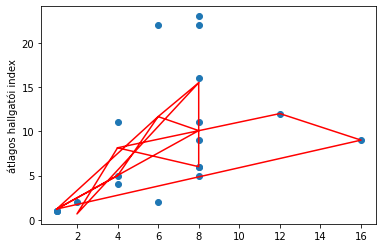

In [11]:
plt.scatter(X.ÁHI, y)
plt.plot(X.ÁHI, y_pred, 'r')
plt.ylabel('átlagos hallgatói index')
plt.show()

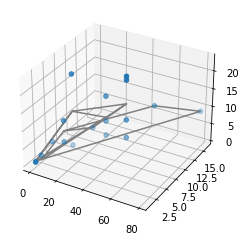

In [12]:
ax = plt.axes(projection='3d')
ax.scatter3D(X.KHI, X.ÁHI, y);
ax.plot(X.KHI, X.ÁHI, y_pred, "gray")

Végül a Support Vector Machines alá tartozó Support Vector Regression osztályt vizsgáltam. Ezen belül három kernel módot próbáltam ki, ezek a Radial basis function, Lineáris és Polinom. Mindhárom módot skálázással és anélkül is vizsgáltam.
Míg az RBF esetében a skálázás rontott az eredményen, a Polinomnál 10%-ot javított. (A lineáris módnál nem változott, hiszen a skálázás maga is egy lineáris művelet.) Az RBF (skálázás nélkül) érte el a legmagasabb determinációs együttható értéket (0.3689). 

In [13]:
svr_rbf = svm.SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = svm.SVR(kernel="linear", C=100, gamma="auto")
svr_poly = svm.SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
models = [("RBF", svr_rbf), ("LIN", svr_lin), ("POLY", svr_poly)]
print("Models without scaling: ")
for name, model in models:
    model.fit(X, y)
    print("R\u00b2 of %s = %s" % (name, model.score(X, y)))
    
print("Models with scaling: ")
for name, model in models:
    ppl = make_pipeline(StandardScaler(), model)
    ppl.fit(X, y)
    print("R\u00b2 of %s = %s" %(name, ppl.score(X, y)))

Models without scaling: 
R² of RBF = 0.3688721567069023
R² of LIN = 0.24929729452455573
R² of POLY = 0.22802900236501988
Models with scaling: 
R² of RBF = 0.3210680161727999
R² of LIN = 0.2492653929695431
R² of POLY = 0.3225014944693484


## 4. Igazságosság

Most, hogy elő tudjuk állítani a releváns bemeneti adatokat és van némi tapasztalatunk pár regressziós modellel, ideje megválaszolni az eredeti kérdést: igazságos-e a beosztás. 

A 3. pont alapján a polinomiális regresszió érte el a legjobb eredményt, így ezt választottam alapértelmezett modellnek. Ez felülírható az osztály példányosításakor. 

A hatékonyság növelése érdekében ahelyett, hogy az igazságosság ellenőrzésének minden futásakor újra beolvassuk és feldolgozzuk az Excel fájlt (egy úgy `ScheduleStats` osztály létrehozásával), a `pickle` modul segítségével az osztályt háttértárba mentjük és szükség esetén betöltjük memóriába. Ha változtatásokat eszközlünk a `ScheduleStats` osztályon, adjunk `True` értéket a `force_reload` argumentumnak egy `FairnessChecker`példányosításakor, hogy elkerüljük a régebbi verzió memóriába olvasását. 

### 4.1 Az igazságosság ellenőrzése

Az igazságosság ellenőrzésének elve, hogy két diszkjunkt halmazra bontjuk az oktatókat. 

Az első halmaz a "vizsgáztatók" halmaza. Itt a három, fent definiált oktatókra jellemző lesz a regresszió inputjának 3 dimenziója. A negyedik, "extra" dimenzió azt fejezi ki, hogy az egyes oktatók hány vizsgán vettek részt úgy, mint nem vizsgáztató. (Korábban az egyes szerepekben eltöltött vizsgaalkalmak számát külön dimenziókként kezeltem, de ekkor túlságosan túlilleszkedett a modell az adatokra. Ezt kiküszöböltem azzal, hogy ezeket az értékeket összeadom és egy dimenzióban tárolom.) 

A második halmaz az "egyéb" halmaz, azaz a nem vizsgáztató oktatók. Náluk az igazságosság kérdése triviálisabb, az ő esetükben nem használtam regressziós modellt, csupán a munkavégzésük átlagát vettem. 

> **Megjegyzés:** Valószínű, hogy jobb eredmény érhető el, ha a kiugró értékeket nem vesszük figyelembe (mindkét halmaz esetén). 

In [24]:
import os, pickle
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [27]:
class FairnessChecker:
    '''
    Regressziós modell segítségével az igazságosságot eldöntő osztály.
    
    Attribútumok
    ------------
        model : Regression Model (train és fit metódusokkal)
    '''
    
    SAVED_DATASET = './data/schedule_dataset.pickle'
    
    def _load_pickled(self, path):
        with open(path, mode = 'rb') as f:
            return pickle.load(f)
        
    def _pickle_obj(self, obj, path):
        with open(path, mode = 'wb') as f:
            pickle.dump(obj, f)
        
    def _init_dataset(self, force_reload):
        ''' A függvény kezeli a ScheduleStats() példány betöltését memóriába, korábbi mentésről vagy új példány létrehozásával. '''
        path = FairnessChecker.SAVED_DATASET
        
        if os.path.exists(path) and not force_reload:
            self.dataset = self._load_pickled(path)
        else:
            self.dataset = ScheduleStats()
            self._pickle_obj(self.dataset, path)        
            
    def default_model(): 
        default_poly_degree = 2
        pipeline = Pipeline([
            ("polynomial_features", PolynomialFeatures(degree = default_poly_degree, include_bias = False)), 
            ("linear_regression", LinearRegression()),
        ])
        return pipeline
    
    def __init__(self, model = default_model, force_reload = False):
        # A model változó lehet egy függvény is, mely a modellt adja vissza, ekkor meghívjuk. (Pl. alapértelmezett viselkedés)
        if callable(model):
            self.model = model()
        else:
            self.model = model
        # ScheduleStats példány létrehozása / betöltése
        self._init_dataset(force_reload)
        
    def train_data(self, 
                   select = True, 
                   project = ["Elnök", "Tag", "Titkár", "OTI", "KHI", "ÁHI"], 
                   aggregate = None,
                   workload_weights = np.ones(4)):
        '''
        A függvény a reg. modell bemenetét állítja elő az argumentumban kapott
        adatmanipulációs lépések elvégzésével. 
        
        Argumentumok
        ------------
            select : függvény, bool visszatérési értékkel
            project : azon oszlopnev(ek), amely(ek) végül a modell bemenetének egy-egy dimenziójának felelnek meg. 
            aggregate : 3-tuple, (aggr_from, aggr_to, lambda)
                aggr_from : az oszlopnevek, melyek értékei az aggregált értékben felhasználásra kerülnek
                aggr_to : az új oszlopnév neve, mely az aggregált értéket tartalmazza
                lambda : a függvény, amivel megkapható az aggregált érték (pl. sum)
            workload_weights : a munkateher kiszámításához szükséges súlyok (ld. ScheduleStats workload metódus)            
        '''
        
        df = self.dataset.teachers
        if aggregate:
            aggr_from, aggr_to, aggr_lam = aggregate
            df[aggr_to] = df[aggr_from].apply(aggr_lam, axis = 1)
        df = df[select]
        wl = ScheduleStats.workload(df, workload_weights)
        return df[project], wl
    
    def fit(self, X, y):
        self.model.fit(X, y)
        
    def predict(self, X):
        return self.model.predict(X)
    
    def _examiner_fair_check():
        ''' 
        A vizsgáztatók halmazára előállítja a tényleges és előrejelzett munkaterhet. 
        
        A függvény egy DataFrame példánnyal tér vissza, melynek két oszlopa a "Munka" és "Pred", 
        mely a tényleges és előrejelzett munkateher értékeket tartalmazza, az indexeket az eredeti
        teachers DataFrame szerint megőrizve.
        '''
        
        checker = FairnessChecker()    
        teacher_selection = ScheduleStats.select_subset("vizsgáztatók")
        X, y = checker.train_data(
            select = teacher_selection,
            project = ["Extra", "OTI", "KHI", "ÁHI"],
            aggregate = (["Elnök", "Tag", "Titkár"], "Extra", lambda df: df.sum()),
            workload_weights = (1., 0., 0., 0.),
        )
        checker.fit(X, y)
        y_pred = pd.Series(checker.predict(X).round(2), name = "Pred")
        return pd.concat([y, y_pred], axis = 1)
        
    def _others_fair_check(checker):
        '''
        A függvény a nem vizsgáztató tanárokra állítja elő a jósolt munkateher értékeket.
        
        A függvény, hasonlóképpen az _examiner_fair_check-hez, egy "Munka" és "Pred" oszlopokból
        álló DataFrame példánnyal tér vissza, melyben az egyes sorok indexe az eredeti 
        teachers DataFrame-mel azonos. 
        '''
        
        X = ScheduleStats.subset(checker.dataset.teachers, "egyéb")
        y = ScheduleStats.workload(X, workload_weights = (0, 1, 1, 1))
        y_pred = pd.Series(round(np.mean(y),2), index = y.index, name = "Pred")
        return pd.concat([y, y_pred], axis = 1)
    
    def fair_check(threshold = 1.0):
        '''
        A függvény visszaadja a nem igazságos bánásmódban részesült
        tanárokra vonatkozó tényleges és előrejelzett munkateher adatokat. 
        
        A függvény kiszámolja a négyzetes eltérést a tényleges és jósolt értékek között, ezeket
        standardizálja. Ha az eltérés nagyobb, mint az argumentumban kapott küszöbérték, 
        az ezen tanárok adatait visszaadja. 
        '''
        
        checker = FairnessChecker()

        examiners_df = FairnessChecker._examiner_fair_check()
        others_df = FairnessChecker._others_fair_check(checker)
        fairness_df = examiners_df.append(others_df)
        # Név oszlop hozzáfűzése, szemléltetés kedvéért
        fairness_df = pd.concat([checker.dataset.teachers["Név"], fairness_df], axis = 1)
        
        # Standardizálás
        scaler = StandardScaler(with_mean = False)
        fairness_df["Std_Pred"] = (fairness_df.Munka - fairness_df.Pred)**2
        fairness_df["Std_Pred"] = scaler.fit_transform(fairness_df["Std_Pred"].values.reshape((-1,1))).round(2)
        
        return fairness_df[fairness_df.Std_Pred > threshold]

### 4.2 Használat

In [22]:
import matplotlib.pyplot as plt

def plot_results(Y, Y_pred):
    nth = lambda t,n: [e[n] for e in t]
    
    Y_s = sorted(zip(Y, Y_pred), key = lambda x: x[0])
    plt.plot(Y.index, nth(Y_s, 0), "bo")
    plt.plot(Y.index, nth(Y_s, 1), "rs")
    plt.plot((Y.index,Y.index),(nth(Y_s, 0), nth(Y_s, 1)),c='black', linewidth = 1)
    plt.ylabel('Workload')
    plt.show()

A beosztás a modell szerint az alábbi oktatók esetén nem volt igazságos:  


,Név,Munka,Pred,Std_Pred
0,Dr. Dudás Ákos,23.0,13.88,2.76
1,Imre Gábor,6.0,13.88,2.06
22,Dr. Kovács Tibor,21.0,10.39,3.74
30,Kovács László,1.0,10.39,2.93
33,Dr. Nagy Ákos,4.0,10.39,1.36
35,Sik Tamás Dávid,21.0,10.39,3.74
36,Veréb Szabolcs,16.0,10.39,1.04


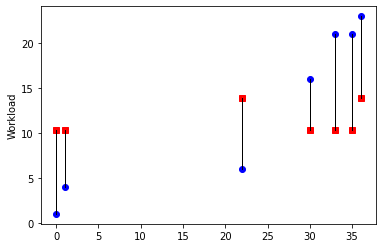

In [28]:
unfair_results = FairnessChecker.fair_check(threshold = 1.)
if unfair_results.empty: 
    print("A beosztás a modell szerint igazságos!")
else:
    print("A beosztás a modell szerint az alábbi oktatók esetén nem volt igazságos:  ")
    display(unfair_results)
    plot_results(unfair_results.Munka, unfair_results.Pred)

## 5. Lehetséges fejlesztési irányok

Feltehetően nem lesz ugyanolyan sémájú az összes bemeneti excel fájlunk. `A ScheduleStats` osztály jelen formájában egy konkrét bemeneti fájlból indul ki. Érdemes lehet a beolvasott fájl feldolgozását lambda függvényeken keresztül elvégezni és a mostani, fájlspecifikus feldolgozást alapértelmezettként kezelni. Alternatíva lehet egy leszármazott osztályban implementálni az összes, a 2020-as bemeneti Excel fájlra jellemző feldolgozást, így növelve a kód újrafelhasználhatóságát.  

A kód követhetősége érdekében érdemes lehet áttérni mindenhol az angol terminológiára. A DataFramek oszlopnevei egyelőre szimplán átveszik a beolvasott fájl fejléceit, így a kódban is sok helyen zavaró lehet a magyar. (Másrészről viszont igaz, hogy a kód teljes egészében a BME-VIK záróvizsgabeosztásainak igazságosságával foglalkozik, helyénvaló lehet meghagyni változatlanul az oszlopokat.)

A regresszió alaposabb kiértékelése és alternatív módszerek tesztelése szükséges. A kiugró értékeket mindenképpen figyelmen kívül hagynám a modell betanításakor. Másrészről csökkenteném a dimenziók számát a "vizsgáztatók" részhalmaza esetén, ezzel segítve a túlilleszkedésen.

A személyes adatokat (Név) csak addig használjuk, amíg tényleg relevánsak az adatok feldolgozásakor, később ne legyenek elérhetőek. (GDPR :)

Konzulens szerep bevonása.